In [1]:
#| hide
import nbdev; nbdev.nbdev_export()
import kglab
import pandas as pd
from pandas import DataFrame

# Core Functions

This page defines all boilerplate functions to be used when analyzing sboms.  To see these functions in action please view the following pages.

Many of the queries seen on this page were written with the help of ChatGPT.  To repeat this simply prompt ChatGPT as follows: 
`Write me a SPARQL query to select X, Y, and Z`

#| hide
### Load KG for testing

In [2]:
#| hide
kg = kglab.KnowledgeGraph()
kg.load_rdf("../../sboms/rdf/model.rdf.xml", format="xml")

## Basic Queries

These functions perform basic queries and return metadata about a given knowledge graph

In [3]:
#| export
from kglab import KnowledgeGraph
def show_metadata(kg:KnowledgeGraph, #Knowledge graph to query from
                  dataframe: bool=False): #Optionally, return result to dataframe
    """
    Return total number of triples, distict entities, and properties to a pandas dataframe.
    """
    
    query = """
    SELECT 
        (COUNT(*) AS ?triples)
        (COUNT(DISTINCT ?entity) AS ?entities)
        (COUNT(DISTINCT ?property) AS ?properties)
    WHERE {
        ?subject ?property ?object .
        BIND(?subject AS ?entity) .
    }
    """

    if dataframe:
        return kg.query_as_df(query)

    for row in kg.query(query):
        print("Total Triples:", row['triples'])
        print("Distinct Entities:", row['entities'])
        print("Distinct Properties:", row['properties'])

In [4]:
#| hide
show_metadata(kg)

Total Triples: 306
Distinct Entities: 56
Distinct Properties: 62


In [5]:
#| export
from kglab import KnowledgeGraph
def show_entity_types(kg: KnowledgeGraph, # Knowledge graph to query from 
                      dataframe: bool=False): # Optionally, return result to dataframe
    """
    Show counts of entity types
    """
    
    query = """
    SELECT ?type (COUNT(?entity) as ?count)
    WHERE {
        ?entity a ?type .
    }
    GROUP BY ?type
    ORDER BY DESC(?count)
    """
    
    if dataframe:
        return kg.query_as_df(query)

    result = kg.query(query)
    for row in result:
        print(row["type"], ":", row["count"])


In [6]:
#| hide
show_entity_types(kg)

http://spdx.org/rdf/terms#Relationship : 11
http://spdx.org/rdf/terms#Checksum : 10
http://spdx.org/rdf/terms#ExtractedLicensingInfo : 5
http://spdx.org/rdf/terms#Annotation : 5
http://spdx.org/rdf/terms#Package : 4
http://spdx.org/rdf/terms#File : 4
http://spdx.org/rdf/terms#ExternalRef : 3
http://spdx.org/rdf/terms#DisjunctiveLicenseSet : 2
http://www.w3.org/2009/pointers#StartEndPointer : 2
http://www.w3.org/2009/pointers#ByteOffsetPointer : 2
http://www.w3.org/2009/pointers#LineCharPointer : 2
http://spdx.org/rdf/terms#SpdxDocument : 1
http://spdx.org/rdf/terms#PackageVerificationCode : 1
http://spdx.org/rdf/terms#ConjunctiveLicenseSet : 1
http://spdx.org/rdf/terms#CreationInfo : 1
http://spdx.org/rdf/terms#ExternalDocumentRef : 1
http://spdx.org/rdf/terms#Snippet : 1


In [7]:
#| export
from kglab import KnowledgeGraph
def show_top_n_props(kg: KnowledgeGraph,  # Knowledge graph to query from
                     n: int=10, # Top n results to display
                     dataframe: bool=False): # Optionally, return result to dataframe
    """
    Display the top N properties from a knowledge graph
    """
    
    query = """
    SELECT ?property (COUNT(?property) as ?count)
    WHERE {
        ?s ?property ?o .
    }
    GROUP BY ?property
    ORDER BY DESC(?count)
    LIMIT %d
    """ % n
    
    if dataframe:
        return kg.query_as_df(query)

    result = kg.query(query)
    for row in result:
        print(row["property"], ":", row["count"])

In [8]:
#| hide
show_top_n_props(kg, 10, dataframe=True)

,property,count
0,rdf:type,56
1,rdfs:comment,14
2,spdx:relationship,11
3,spdx:relatedSpdxElement,11
4,spdx:relationshipType,11
5,spdx:fileContributor,11
6,spdx:algorithm,10
7,spdx:checksum,10
8,spdx:checksumValue,10
9,spdx:licenseConcluded,9


In [9]:
#| export
from kglab import KnowledgeGraph
def show_measures(kg:KnowledgeGraph): #Knowledge graph to query from
    """
    Display number of nodes and edges for knowledge graph
    """
    measure = kglab.Measure()
    measure.measure_graph(kg)

    print("edges", measure.get_edge_count())
    print("nodes", measure.get_node_count())

## Files

These functions peform queries on a SBOM's files

In [10]:
#| export
def file_schema(kg:KnowledgeGraph): #Knowledge graph to query from
  """
  Display all properties for a file
  """
  query = """
  PREFIX spdx:<http://spdx.org/rdf/terms#>
  SELECT DISTINCT ?property
  WHERE {
    ?file rdf:type spdx:File .
    ?file ?property ?value .
  }
  order by asc(UCASE(str(?property)))
  """
  return kg.query_as_df(query)

In [11]:
#| hide
file_schema(kg)

,property
0,spdx:annotation
1,spdx:checksum
2,spdx:copyrightText
3,spdx:fileContributor
4,spdx:fileName
5,spdx:fileType
6,spdx:licenseComments
7,spdx:licenseConcluded
8,spdx:licenseInfoInFile
9,spdx:noticeText


In [12]:
#| export
from pandas import DataFrame
def get_files_data(kg:KnowledgeGraph #Knowledge graph to query from
                   ) -> DataFrame: #Return result to dataframe
    """
    Return all files and their properties
    """
    query = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    SELECT 
    (?file AS ?fileID)
    ?fileName
    ?fileType
    ?licenseInFile
    (GROUP_CONCAT(?contributor; SEPARATOR=", ") AS ?contributors)
    (GROUP_CONCAT(?licenseConcluded; SEPARATOR=", ") AS ?licenseConcluded)
    ?checksum
    ?relationship
    ?annotation
    ?comment
    ?licenseComments
    ?noticeText
    WHERE {
    ?file rdf:type spdx:File .
    OPTIONAL {?file spdx:fileName ?fileName .}
    OPTIONAL {?file spdx:fileContributor ?contributor .}
    OPTIONAL {?file spdx:licenseInfoInFile ?licenseInFile .}
    OPTIONAL {?file spdx:licenseConcluded ?licenseConcluded .}
    OPTIONAL {?file spdx:checksum ?checksum .}
    OPTIONAL {?file spdx:copyrightText ?copyrightText .}
    OPTIONAL {?file spdx:fileType ?fileType .}
    OPTIONAL {?file spdx:relationship ?relationship .}
    OPTIONAL {?file spdx:annotation ?annotation . }
    OPTIONAL {?file rdfs:comment ?comment . }
    OPTIONAL {?file spdx:licenseComments ?licenseComments . }
    OPTIONAL {?file spdx:noticeText ?noticeText . }
    }
    GROUP BY ?file
    """

    return kg.query_as_df(query)

In [13]:
#| hide
get_files_data(kg)

,fileID,fileName,fileType,licenseInFile,contributors,licenseConcluded,checksum,relationship,comment,licenseComments,noticeText,annotation
0,<http://spdx.org/spdxdocs/spdx-example-444504E...,./lib-source/jena-2.6.3-sources.jar,spdx:fileType_archive,<http://spdx.org/spdxdocs/spdx-example-444504E...,"Apache Software Foundation, Hewlett Packard Inc.",http://spdx.org/spdxdocs/spdx-example-444504E0...,_:N2df91c73797548a68e12bb5e5cf94132,_:N12a644bd6b854065a34817c770cb7d5f,This file belongs to Jena,This license is used by Jena,NaN,NaN
1,<http://spdx.org/spdxdocs/spdx-example-444504E...,./lib-source/commons-lang3-3.1-sources.jar,spdx:fileType_archive,<http://spdx.org/licenses/Apache-2.0>,Apache Software Foundation,http://spdx.org/licenses/Apache-2.0,_:N2f78cfda2f7f42128a94c20f5841b102,_:N6358e1260b364de898b8a291d3ae00b4,This file is used by Jena,NaN,Apache Commons Lang\nCopyright 2001-2011 The A...,NaN
2,<http://spdx.org/spdxdocs/spdx-example-444504E...,./src/org/spdx/parser/DOAPProject.java,spdx:fileType_source,<http://spdx.org/licenses/Apache-2.0>,"Source Auditor Inc., Black Duck Software In.c,...","http://spdx.org/licenses/Apache-2.0, http://sp...",_:N1c1cadca31014513adcb5a82795a9de0,NaN,NaN,NaN,NaN,NaN
3,<http://spdx.org/spdxdocs/spdx-example-444504E...,./package/foo.c,spdx:fileType_source,<http://spdx.org/spdxdocs/spdx-example-444504E...,"IBM Corporation, IBM Corporation, IBM Corporat...","N927ff8b16bd9404db9d1c7b593551c8c, N927ff8b16b...",_:N28579fbb821448718507464d01f26956,_:N0377cbb2ae264464826de0d60fb414d6,The concluded license was taken from the packa...,The concluded license was taken from the packa...,Copyright (c) 2001 Aaron Lehmann aaroni@vitelu...,_:N16f630e758b54a12ae98a4fc8092e540


In [14]:
#| export
def get_files_graph(kg:KnowledgeGraph #Knowledge graph to query from
                    )-> KnowledgeGraph: #Return result to knowledge graph
    """
    Return a subgraph of the files and their properties
    """
    namespaces = {
        "spdx": "http://spdx.org/rdf/terms#"
    }
    subgraph = kglab.KnowledgeGraph(
        namespaces = namespaces,
    )
    query = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    CONSTRUCT {
        ?file rdf:type spdx:File .
        ?file spdx:fileName ?fileName .
        ?file spdx:fileContributor ?contributor .
        ?file spdx:licenseInfoInFile ?licenseInFile .
        ?file spdx:checksum ?checksum .
        ?file spdx:relationship ?relationship .
    }
    WHERE {
        ?file rdf:type spdx:File .
        OPTIONAL {?file spdx:fileName ?fileName .}
        OPTIONAL {?file spdx:fileContributor ?contributor .}
        OPTIONAL {?file spdx:licenseInfoInFile ?licenseInFile .}
        OPTIONAL {?file spdx:relationship ?relationship .}
    }
    """

    for row in kg.query(query):
        s, p, o = row
        subgraph.add(s, p, o)

    return subgraph # Return the subgraph

## Packages



In [15]:
#| export
def package_schema(kg:KnowledgeGraph #Knowledge graph to query from
                  )-> DataFrame: #Return result to dataframe
  """
  Return the schema for the package
  """
  query = """
  PREFIX spdx:<http://spdx.org/rdf/terms#>
  SELECT DISTINCT ?property
  WHERE {
    ?package rdf:type spdx:Package .
    ?package ?property ?value .
  }
  order by asc(UCASE(str(?property)))
  """
  return kg.query_as_df(query)

In [16]:
#| hide
package_schema(kg)

,property
0,spdx:annotation
1,spdx:attributionText
2,spdx:checksum
3,spdx:copyrightText
4,spdx:description
5,spdx:downloadLocation
6,spdx:externalRef
7,spdx:filesAnalyzed
8,spdx:licenseComments
9,spdx:licenseConcluded


In [17]:
#| export
def get_package_data(kg:KnowledgeGraph #Knowledge graph to query from
                     ) -> DataFrame: #Return result to dataframe
    """
    Construct a dataframe of package data
    """
    query = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    SELECT ?package
        (GROUP_CONCAT(?annotation; SEPARATOR=", ") AS ?annotations)
        (GROUP_CONCAT(?attributionText; SEPARATOR=", ") AS ?attributionTexts)
        ?builtDate
        (GROUP_CONCAT(?checksum; SEPARATOR=", ") AS ?checksums)
        ?comment
        ?copyrightText
        ?description
        ?downloadLocation
        (GROUP_CONCAT(?externalRef; SEPARATOR=", ") AS ?externalRefs)
        ?filesAnalyzed
        (GROUP_CONCAT(?hasFile; SEPARATOR=", ") AS ?hasFiles)
        ?homepage
        ?licenseComments
        ?licenseConcluded
        ?licenseDeclared
        (GROUP_CONCAT(?licenseInfoFromFile; SEPARATOR=", ") AS ?licenseInfoFromFiles)
        ?name
        ?originator
        ?packageFileName
        ?packageVerificationCode
        ?primaryPackagePurpose
        ?releaseDate
        ?sourceInfo
        ?summary
        ?supplier
        ?validUntilDate
        ?versionInfo
        (GROUP_CONCAT(?relationship; SEPARATOR=", ") AS ?relationships)
    WHERE {
        ?package rdf:type spdx:Package .
        OPTIONAL { ?package spdx:annotation ?annotation . }
        OPTIONAL { ?package spdx:attributionText ?attributionText . }
        OPTIONAL { ?package spdx:builtDate ?buildDate . }
        OPTIONAL { ?package spdx:checksum ?checksum . }
        OPTIONAL { ?package spdx:comment ?comment . }
        OPTIONAL { ?package spdx:copyrightText ?copyrightText . }
        OPTIONAL { ?package spdx:description ?description . }
        OPTIONAL { ?package spdx:downloadLocation ?downloadLocation . }
        OPTIONAL { ?package spdx:externalRef ?externalRef . }
        OPTIONAL { ?package spdx:filesAnalyed ?filesAnalyzed . }
        OPTIONAL { ?package spdx:hasFile ?hasFile . }
        OPTIONAL { ?package spdx:homepage ?homepage . }
        OPTIONAL { ?package spdx:licenseComments ?licenseComments . }
        OPTIONAL { ?package spdx:licenseConcluded ?licenseConcluded . }
        OPTIONAL { ?package spdx:licenseDeclared ?licenseDeclared . }
        OPTIONAL { ?package spdx:licenseInfoFromFile ?licenseInfoFromFile . }
        OPTIONAL { ?package spdx:name ?name . }
        OPTIONAL { ?package spdx:originator ?originator . }
        OPTIONAL { ?package spdx:packageFileName ?packageFileName . }
        OPTIONAL { ?package spdx:packageVerificationCode ?packageVerificationCode . }
        OPTIONAL { ?package spdx:primaryPackagePurpose ?primaryPackagePurpose . }
        OPTIONAL { ?package spdx:releaseDate ?releaseDate . }
        OPTIONAL { ?package spdx:sourceInfo ?sourceInfo . }
        OPTIONAL { ?package spdx:summary ?summary . }
        OPTIONAL { ?package spdx:supplier ?supplier . }
        OPTIONAL { ?package spdx:validUntilDate ?validUntilDate . }
        OPTIONAL { ?package spdx:versionInfo ?versionInfo . }
        OPTIONAL { ?package spdx:relationship ?relationship . }
    }
    GROUP BY ?package
    """

    return kg.query_as_df(query)

In [18]:
#| hide
get_package_data(kg)

,package,annotations,attributionTexts,checksums,copyrightText,downloadLocation,externalRefs,hasFiles,licenseConcluded,licenseDeclared,...,relationships,description,licenseComments,originator,packageFileName,packageVerificationCode,sourceInfo,summary,supplier,versionInfo
0,<http://spdx.org/spdxdocs/spdx-example-444504E...,,,,NOASSERTION,spdx:noassertion,,,spdx:noassertion,spdx:noassertion,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,<http://spdx.org/spdxdocs/spdx-example-444504E...,"Nf79eb74f00b4449e8d1b4c3dc68ec03a, Nf79eb74f00...",The GNU C Library is free software. See the f...,"Nb715d9c9b51945529fef4b45efba76b2, Nb715d9c9b5...",Copyright 2008-2010 John Smith,http://ftp.gnu.org/gnu/glibc/glibc-ports-2.15....,"Na44ccbec217244cab06662c07980290d, Na44ccbec21...",,_:N5fc6bacd8a704374a631f6cb08711531,_:Na23be0e02e364de0bd90e71399ff8842,...,"N5161c81fb5274b42a7b3841864ab231c, N090bd4f4e4...",The GNU C Library defines functions that are s...,The license for this project changed with the ...,Organization: ExampleCodeInspect (contact@exam...,glibc-2.11.1.tar.gz,_:Nbbbe916cf90e414f943c029b53a1d4f6,uses glibc-2_11-branch from git://sourceware.o...,GNU C library.,Person: Jane Doe (jane.doe@example.com),2.11.1
2,<http://spdx.org/spdxdocs/spdx-example-444504E...,,,N92757495b7b6443e994f5eecc3bf3f68,Copyright Saxonica Ltd,https://sourceforge.net/projects/saxon/files/S...,,,<http://spdx.org/licenses/MPL-1.0>,<http://spdx.org/licenses/MPL-1.0>,...,,The Saxon package is a collection of tools for...,Other versions available for a commercial license,NaN,saxonB-8.8.zip,NaN,NaN,NaN,NaN,8.8
3,<http://spdx.org/spdxdocs/spdx-example-444504E...,,,,NOASSERTION,https://search.maven.org/remotecontent?filepat...,Nea98d4ba0a81479b85c993346125c788,,spdx:noassertion,spdx:noassertion,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.12.0


In [19]:
#| export
def get_package_graph(kg:KnowledgeGraph #Knowledge graph to query from
                      ) -> KnowledgeGraph: #Return result to knowledge graph
    """
    Construct a subgraph of the package data
    """
    namespaces = {
        "spdx": "http://spdx.org/rdf/terms#"
    }   

    subgraph = kglab.KnowledgeGraph(
        namespaces = namespaces,
    )   

    query = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    CONSTRUCT {
        ?package rdf:type spdx:Package .
        ?package spdx:annotation ?annotation .
        ?package spdx:attributionText ?attributionText .
        ?package spdx:builtDate ?buildDate .
        ?package spdx:checksum ?checksum .
        ?package spdx:comment ?comment .
        ?package spdx:copyrightText ?copyrightText .
        ?package spdx:description ?description .
        ?package spdx:downloadLocation ?downloadLocation .
        ?package spdx:externalRef ?externalRef .
        ?package spdx:filesAnalyed ?filesAnalyzed .
        ?package spdx:hasFile ?hasFile .
        ?package spdx:homepage ?homepage .
        ?package spdx:licenseComments ?licenseComments .
        ?package spdx:licenseConcluded ?licenseConcluded .
        ?package spdx:licenseDeclared ?licenseDeclared .
        ?package spdx:licenseInfoFromFile ?licenseInfoFromFile .
        ?package spdx:name ?name .
        ?package spdx:originator ?originator .
        ?package spdx:packageFileName ?packageFileName .
        ?package spdx:packageVerificationCode ?packageVerificationCode .
        ?package spdx:primaryPackagePurpose ?primaryPackagePurpose .
        ?package spdx:releaseDate ?releaseDate .
        ?package spdx:sourceInfo ?sourceInfo .
        ?package spdx:summary ?summary .
        ?package spdx:supplier ?supplier .
        ?package spdx:validUntilDate ?validUntilDate .
        ?package spdx:versionInfo ?versionInfo .
        ?package spdx:relationship ?relationship .
    }   
    WHERE {
        ?package rdf:type spdx:Package .
        OPTIONAL { ?package spdx:annotation ?annotation . }
        OPTIONAL { ?package spdx:attributionText ?attributionText . }
        OPTIONAL { ?package spdx:attributionText ?attributionText . }
        OPTIONAL { ?package spdx:builtDate ?buildDate . }
        OPTIONAL { ?package spdx:checksum ?checksum . }
        OPTIONAL { ?package spdx:comment ?comment . }
        OPTIONAL { ?package spdx:copyrightText ?copyrightText . }
        OPTIONAL { ?package spdx:description ?description . }
        OPTIONAL { ?package spdx:downloadLocation ?downloadLocation . }
        OPTIONAL { ?package spdx:externalRef ?externalRef . }
        OPTIONAL { ?package spdx:filesAnalyed ?filesAnalyzed . }
        OPTIONAL { ?package spdx:hasFile ?hasFile . }
        OPTIONAL { ?package spdx:homepage ?homepage . }
        OPTIONAL { ?package spdx:licenseComments ?licenseComments . }
        OPTIONAL { ?package spdx:licenseConcluded ?licenseConcluded . }
        OPTIONAL { ?package spdx:licenseDeclared ?licenseDeclared . }
        OPTIONAL { ?package spdx:licenseInfoFromFile ?licenseInfoFromFile . }
        OPTIONAL { ?package spdx:name ?name . }
        OPTIONAL { ?package spdx:originator ?originator . }
        OPTIONAL { ?package spdx:packageFileName ?packageFileName . }
        OPTIONAL { ?package spdx:packageVerificationCode ?packageVerificationCode . }
        OPTIONAL { ?package spdx:primaryPackagePurpose ?primaryPackagePurpose . }
        OPTIONAL { ?package spdx:releaseDate ?releaseDate . }
        OPTIONAL { ?package spdx:sourceInfo ?sourceInfo . }
        OPTIONAL { ?package spdx:summary ?summary . }
        OPTIONAL { ?package spdx:supplier ?supplier . }
        OPTIONAL { ?package spdx:validUntilDate ?validUntilDate . }
        OPTIONAL { ?package spdx:versionInfo ?versionInfo . }
        OPTIONAL { ?package spdx:relationship ?relationship . }
    }
    GROUP BY ?package
    """
    for row in kg.query(query):
        s, p, o = row
        subgraph.add(s, p, o)

    return subgraph # Return the subgraph

## Relationships

In [20]:
#| export
def relationship_schema(kg : KnowledgeGraph #Knowledge graph to query from
                        ) -> DataFrame: #Return result to dataframe
    """
    Return the schema for the relationships
    """

    query = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    SELECT DISTINCT ?property
    WHERE {
    ?file rdf:type spdx:Relationship .
    ?file ?property ?value .
    }
    """


    return kg.query_as_df(query)


In [21]:
#| hide
relationship_schema(kg)

,property
0,rdf:type
1,spdx:relationshipType
2,spdx:relatedSpdxElement


In [22]:
#| export
def get_relationship_data(kg:KnowledgeGraph #Knowledge graph to query from
                          ) -> DataFrame: #Return result to dataframe
    
    query = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    SELECT ?element ?elementType ?relationshipType ?relatedElement ?relatedElementType
    WHERE {
    ?element spdx:relationship ?relationship .
    ?element rdf:type ?elementType .
    ?relationship spdx:relatedSpdxElement ?relatedElement .
    ?relationship spdx:relationshipType ?relationshipType .
    ?relatedElement rdf:type ?relatedElementType .
    }
    """

    return kg.query_as_df(query)

In [23]:
#| hide
get_relationship_data(kg)

,element,elementType,relationshipType,relatedElement,relatedElementType
0,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:File,spdx:relationshipType_contains,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package
1,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package,spdx:relationshipType_contains,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:File
2,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package,spdx:relationshipType_dynamicLink,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package
3,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package,spdx:relationshipType_contains,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:File
4,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package,spdx:relationshipType_contains,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:File
5,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:SpdxDocument,spdx:relationshipType_contains,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package
6,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:File,spdx:relationshipType_generatedFrom,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package
7,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:SpdxDocument,spdx:relationshipType_describes,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:File
8,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:SpdxDocument,spdx:relationshipType_describes,<http://spdx.org/spdxdocs/spdx-example-444504E...,spdx:Package


In [24]:
#| export
def get_relationship_graph(kg: KnowledgeGraph #Knowledge graph to query from
                           ) -> KnowledgeGraph: #Return result to knowledge graph
    """
    Construct a subgraph of the relationship data
    """

    namespaces = {
    "spdx": "http://spdx.org/rdf/terms#",
    }
    subgraph = kglab.KnowledgeGraph(
        namespaces = namespaces,
    )
    query = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    CONSTRUCT {
    ?element spdx:relationship ?relationship .
    ?element rdf:type ?elementType .
    ?relationship spdx:relatedSpdxElement ?relatedElement .
    ?relationship spdx:relationshipType ?relationshipType .
    ?relatedElement rdf:type ?relatedElementType .
    }
    WHERE {
    ?element spdx:relationship ?relationship .
    ?element rdf:type ?elementType .
    ?relationship spdx:relatedSpdxElement ?relatedElement .
    ?relationship spdx:relationshipType ?relationshipType .
    ?relatedElement rdf:type ?relatedElementType .
    }
    """

    for row in kg.query(query):
        s, p, o = row
        subgraph.add(s, p, o)

    return subgraph

In [25]:
#| hide
get_relationship_graph(kg)

## Quality Metrics

In [26]:
#| export
import pandas as pd
from pandas import DataFrame
import json, glob
from os.path import join
from typing import Tuple

def sbomqs_scores(
    sbomqs_dir: str # Directory for the json files generated by the sbomqs tool
    ) -> Tuple[ DataFrame, DataFrame]: # Return two DataFrames, one with the information about each file in `sbomqs_dir` and another with scores for each feature in the SBOM quality categories for all files
    """
    Create DataFrame with quality scores for the SBOM generation tools.
    """
    
    fname_list = glob.glob(join(sbomqs_dir,"*.json"))

    sbomqs_dct = {       
                'gen_tool_name':[],            
                'avg_score':[],
                'num_components':[],  
                'gen_tool_version':[],
                'spec_version':[],                      
                'file_name':[],
                'scores': [],
                }

    for fname in fname_list:
        data = json.loads(open(fname, "r").read())['files'][0]
        for col in sbomqs_dct.keys():        
            sbomqs_dct[col].append(data[col]) 
        
    sbomqs_df = pd.DataFrame.from_dict(sbomqs_dct)
    sbomqs_df.sort_values(by=['avg_score', 'num_components'], ascending=False, inplace=True)
    
    # get score details
    feature_qscores = pd.concat([ pd.DataFrame.from_dict(row['scores']).assign(tool=row['gen_tool_name']) 
                              for _, row in sbomqs_df.iterrows()])
    
    sbomqs_df.drop('scores', axis=1, inplace=True)
    
    return sbomqs_df, feature_qscores

In [27]:
#| hide
# Example of how to get SBOM quality scores based on json files generated by [sbomqs](https://github.com/interlynk-io/sbomqs) tool.
#
# The input is the path for json files generated using the sbomqs by the following command:
#       $ sbomqs score {sbom_name_generated_by_any_tool.json}  --json >  {quality_score_file_name}.json
#       where `{sbom_name_generated_by_any_tool.json}` is the name of the SBOM file generated by any tool you want to analyze, 
#       and `{quality_score_file_name}.json` is the name of the file that will contain the quality scores.
#
# The output of the function `sbomqs_scores` are two dataframes `sbomqs_df` and `feature_qscores`.

sbomqs_df, feature_qscores = sbomqs_scores("../../data/tools_cs1/sbomqs/")

In [28]:
#| hide
# `sbomqs_df` is a DataFrame with the average quality scores for each tool also some metadata info about the tools and SBOMs generated.
sbomqs_df

,gen_tool_name,avg_score,num_components,gen_tool_version,spec_version,file_name
1,cdxgen,7.424242,24,8.5.3,SPDX-2.2,pytorch-cdxgen-spdx22.json
3,tern,7.381047,181,2.12.0,SPDX-2.2,di-pytorch-tern-spdx22.json
5,FOSSA v0.12.0,7.301136,212,,SPDX-2.3,pytorch-fossa-spdx23.json
8,bom,7.272727,1,v0.5.1,SPDX-2.3,pytorch-bom-spdx23.json
7,GitHub.com-Dependency-Graph,6.829988,231,,SPDX-2.3,pytorch-gh-sbom-spdx23.json
0,syft,6.820443,201,0.83.1,SPDX-2.3,pytorch-syft-spdx23.json
6,trivy,6.774194,124,0.42.1,SPDX-2.3,pytorch-trivy-spdx23.json
2,Microsoft.SBOMTool,6.363636,308,1.1.2,SPDX-2.2,pytorch-sbomtool-spdx22.json
4,sbom4python,3.863636,0,0.9.1,SPDX-2.3,pytorch-sbom4python-spdx23.json


In [29]:
#| hide

# `feature_qscores` is a DataFrame with the quality scores for each feature in each category for all tools.
feature_qscores

,category,feature,score,max_score,description,ignored,tool
0,Structural,sbom_spec,10.0,10,provided sbom is in a supported sbom format of...,False,cdxgen
1,Structural,sbom_spec_version,10.0,10,provided sbom should be in supported spec vers...,False,cdxgen
2,Structural,sbom_spec_file_format,10.0,10,provided sbom should be in supported file form...,False,cdxgen
3,Structural,sbom_parsable,10.0,10,provided sbom is parsable,False,cdxgen
4,NTIA-minimum-elements,comp_with_supplier,0.0,10,0/24 have supplier names,False,cdxgen
...,...,...,...,...,...,...,...
17,Quality,comp_with_restrictive_licenses,0.0,10,N/A (no components),True,sbom4python
18,Quality,comp_with_any_vuln_lookup_id,0.0,10,N/A (no components),True,sbom4python
19,Quality,comp_with_multi_vuln_lookup_id,0.0,10,N/A (no components),True,sbom4python
20,Quality,sbom_with_creator_and_version,10.0,10,1/1 tools have creator and version,False,sbom4python


In [30]:
#| export
import numpy as np
import pandas as pd
from pandas import DataFrame

def sbomqs_score_by_cat(
    feature_qscores: DataFrame  # It is a DataFrame with the quality scores for each feature in each category for all tools.
    ) -> DataFrame:             # Return a DataFrame with the average scores by categories for the SBOM generation tools.            
    """
    Create a DataFrame with the average score by category for each SBOM generation tool
    """
    
    # average score by category
    avg_score_by_cat = pd.pivot_table(feature_qscores, values='score', index=['category'], columns=['tool'], aggfunc=np.mean)

    # Sort by NTIA-minimum-elements
    id_sort = np.argsort(avg_score_by_cat.iloc[0,:].values, axis=-1, order=None)
    avg_score_by_cat = avg_score_by_cat.iloc[:,id_sort[::-1]]
    
    # reset index 
    avg_score_by_cat.reset_index(inplace=True, level=0)

    # show for each tool the average score by category
    return avg_score_by_cat

In [31]:
#| hide
sbomqs_score_by_cat(feature_qscores)

tool,category,tern,FOSSA v0.12.0,Microsoft.SBOMTool,syft,trivy,cdxgen,bom,GitHub.com-Dependency-Graph,sbom4python
0,NTIA-minimum-elements,9.415943,9.184636,8.576067,8.571429,8.502304,7.142857,7.142857,6.988250,2.857143
1,Quality,4.499866,4.172844,2.852505,4.285714,4.216590,5.238095,5.714286,5.003092,1.428571
2,Semantic,4.990792,5.707547,3.333333,3.349917,3.333333,8.888889,6.666667,5.440115,1.666667
3,Sharing,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
4,Structural,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


## Visualization

Functions to visualize graph results

In [32]:
#| export
import kglab
def visualize_graph(kg:KnowledgeGraph, #Knowledge graph to query from
                    VIS_STYLE: str={} #Optional, visualization style
                    ):
    """
    Visualize the knowledge graph
    """
    if not VIS_STYLE:
        VIS_STYLE = {
            "spdx": {
                "color": "orange",
                "size": 40,
            },
            "rdf":{
                "color": "blue",
                "size": 30,
            },
            "ptr":{
                "color": "red",
                "size": 20,
            },
        }
    subgraph = kglab.SubgraphTensor(kg)
    return subgraph.build_pyvis_graph(notebook=True, style=VIS_STYLE)

In [33]:
#| hide

# Create a knowledge graph
kg = kglab.KnowledgeGraph()


# load the knowledge graph info
kg.load_rdf("../../sboms/rdf/model.rdf.xml", format="xml")

pyvis_graph = visualize_graph(kg)
pyvis_graph.force_atlas_2based()
pyvis_graph.show("../figs/tmp.html")

../figs/tmp.html


In [34]:
#| export
import kglab
from pyvis.network import Network

def visualize_relationship_graph(
    kg: KnowledgeGraph,     # Knowledge graph to query from
    hideTypeFile: str=False # Flag for showing SPDX:File type components in the graph
    ) -> Network:           # Return a Network object representing the SBOMs relationship graph

    """
    Construct a Network object for representing the SBOMs components relationship graph.
    The returned graph is ready to be visualized using `.show()`. 
    """
    
    def get_node_title(elmName: str, elmType: str, elmVersion: str, elemPurpose: str) -> str:
        """
        Create a node title. 
        The title will be the node hover text.
        """
        nodeTitle = f"{elmType}: {elmName}"
        if elmVersion:
            nodeTitle += f"\nVersion:{elmVersion}"
        if elemPurpose:
            nodeTitle += "\nPurpose: " + elemPurpose.split("purpose_")[1]
        return nodeTitle

    def get_node_label(elmName: str, elmVersion: str) -> str:
        """
        Create a node label. 
        The label will be the text under the node.
        """
        nodeLabel = elmName
        if elmVersion: nodeLabel += "==" + elmVersion
        return nodeLabel
    
       
    VIS_STYLE = { 
        'SpdxDocument': {
            "color": "#DE3163",
            "size": 20,
        },
        'Package': {
            "color": "#99ccff",
            "size": 20,
        },
        'File': {
            "color": "#FFBF00",
            "size": 15,
        },
    }
    
    SPDX_NS = "http://spdx.org/rdf/terms#"
    
    QUERY = """
    PREFIX spdx:<http://spdx.org/rdf/terms#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    
    SELECT
        ?element
        ?elementName
        ?elementType
        ?elementVersionInfo
        ?elementPrimaryPackagePurpose
        ?relatedElement
        ?relationshipType
        ?relatedElementName
        ?relatedElementType
        ?relatedElementVersionInfo
        ?relatedElementPrimaryPackagePurpose
        
    WHERE {
        ?element spdx:relationship ?relationship .
        ?element rdf:type ?elementType .
        ?relationship spdx:relatedSpdxElement ?relatedElement .
        ?relationship spdx:relationshipType ?relationshipType .
        ?relatedElement rdf:type ?relatedElementType .
        
        OPTIONAL { ?element spdx:name ?elementName . }
        OPTIONAL { ?element spdx:fileName ?elementName . }
        OPTIONAL { ?element spdx:primaryPackagePurpose ?elementPrimaryPackagePurpose . }
        OPTIONAL { ?relatedElement spdx:name ?relatedElementName . }
        OPTIONAL { ?relatedElement spdx:fileName ?relatedElementName . }
        OPTIONAL { ?element spdx:versionInfo ?elementVersionInfo .}
        OPTIONAL { ?relatedElement spdx:versionInfo ?relatedElementVersionInfo .}
        OPTIONAL { ?relatedElement spdx:primaryPackagePurpose ?relatedElementPrimaryPackagePurpose . }
    }
    """
    
    # run query
    query_result = kg.query(QUERY)

    # hide from query_result the components of the spdx:File type     
    if hideTypeFile:
        query_result = [ row for row in query_result if str(row.relatedElementType).split(SPDX_NS)[-1] != "File"]
        
    # create a graph of the relationships using Network
    relationship_graph = Network(notebook=True, directed=True, cdn_resources="remote")
    
    # update the graph of the relationships based on the query_result
    for row in query_result:
        
        # element
        elementName = str(row.elementName)
        elementType = str(row.elementType).split(SPDX_NS)[-1]
        elementVersionInfo = row.elementVersionInfo
        elementPrimaryPackagePurpose= row.elementPrimaryPackagePurpose
        
        # relationship
        relationshipTypeName = row.relationshipType.split("relationshipType_")[1]
        
        # relatedElement        
        relatedElementName = str(row.relatedElementName)
        relatedElementType = str(row.relatedElementType).split(SPDX_NS)[-1]
        relatedElementVersionInfo = row.relatedElementVersionInfo
        relatedElementPrimaryPackagePurpose = row.relatedElementPrimaryPackagePurpose

        ## update graph
        # element Node info
        elementNodeId = row.element 
        elementNodeLabel = get_node_label(elementName, elementVersionInfo)
        elementNodeTitle = get_node_title(elementName, elementType, 
                                          elementVersionInfo, elementPrimaryPackagePurpose)
        elementNodeColor = VIS_STYLE[elementType]['color']
        elementNodeSize = VIS_STYLE[elementType]['size']        
        
        # relatedElement Node info
        relatedElementNodeId = row.relatedElement 
        relatedElementNodeLabel = get_node_label(relatedElementName, relatedElementVersionInfo)
        relatedElementNodeTitle = get_node_title(relatedElementName, relatedElementType, 
                                                 relatedElementVersionInfo, relatedElementPrimaryPackagePurpose)
        relatedElementNodeColor = VIS_STYLE[relatedElementType]['color']
        relatedElementNodeSize = VIS_STYLE[relatedElementType]['size']            
        
        # add nodes (elementName, relatedElementName) to the graph
        relationship_graph.add_node(elementNodeId,
                                    label = elementNodeLabel,
                                    title = elementNodeTitle,
                                    color = elementNodeColor,
                                    size = elementNodeSize
                                   )
        relationship_graph.add_node(relatedElementNodeId,
                                    label = relatedElementNodeLabel,
                                    title = relatedElementNodeTitle,
                                    color = relatedElementNodeColor,
                                    size = relatedElementNodeSize
                                   )
        # and edge(relatedElementName) to the graph
        relationship_graph.add_edge(elementNodeId,
                                    relatedElementNodeId,
                                    title = relationshipTypeName,
                                    label = relationshipTypeName # text over the edge
                                   )
    return relationship_graph

In [35]:
#| export
from pandas import DataFrame
def display_relationship_graph_legend():    
    """
    Display the legend of the SBOMs components relationship graph that can be visualized by `visualize_relationship_graph()`.
    """    
    legend_df = DataFrame([['File', 'Yellow'], ['Package', 'Blue'], ['SPDXDocument', 'Red']], 
                  columns=['SPDX Type', 'Node Color'])

    display(legend_df)


#### How to visualize the relationship graph

You can use the function `visualize_relationship_graph(kg)` where `kg` is a knowledge graph and the returned graph is ready to be visualized using the method `.show()`.

You can also change the physics layout of the graph. In the example below, we are using the option `.force_atlas_2based()`. See the example below. 

In [36]:
# Create a knowledge graph
kg = kglab.KnowledgeGraph()

# load the knowledge graph info
kg.load_rdf("../../sboms/rdf/model.rdf.xml", format="xml")

# get the relationship graph to be visualized
graph = visualize_relationship_graph(kg)

# optional: set the physics layout of the network
graph.force_atlas_2based()
graph.set_edge_smooth('dynamic')

# show graph
graph.show("../figs/fig00.relationship_full.html")

../figs/fig00.relationship_full.html


In [37]:
display_relationship_graph_legend()

,SPDX Type,Node Color
0,File,Yellow
1,Package,Blue
2,SPDXDocument,Red


In [38]:
#| export

from pandas import DataFrame
from IPython.core.display import HTML

def display_qscores_with_descriptions(
    feature_qscores: DataFrame, # DataFrame with the quality scores for each feature in each category for all tools.    
    category_list: list = None, # List of categories to be displayed. If None, all categories are displayed.
    tool_list: list = None      # List of tools to be displayed. If None, all tools are displayed.
    )-> None:
    
    category_list = feature_qscores['category'].unique() if category_list is None else category_list     
    tool_list = feature_qscores['tool'].unique() if tool_list is None else tool_list
    tool_score = feature_qscores[feature_qscores['tool'].isin(tool_list)][['tool', 'score']].groupby('tool').mean().reset_index()
    for tool_name, tool_avg_score in tool_score.values:
        display(HTML(f"<h2>Tool: {tool_name} (avg score: {tool_avg_score:0,.2f})</h2>"))
        for cat in category_list:        
            df = feature_qscores.loc[(feature_qscores['category']==cat) & (feature_qscores['tool']==tool_name)]
            cat_avg_score = df["score"].mean()        
            display(HTML(f"<h3>Category: {cat} (avg score: {cat_avg_score:0,.2f})"))
            display(df[['feature', 'score', 'description', 'tool']])    
            display(HTML(f"<hr>"))


In [39]:
#| hide
display_qscores_with_descriptions(feature_qscores)

,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,FOSSA v0.12.0
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,FOSSA v0.12.0
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,FOSSA v0.12.0
3,sbom_parsable,10.0,provided sbom is parsable,FOSSA v0.12.0


,feature,score,description,tool
4,comp_with_supplier,10.000000,212/212 have supplier names,FOSSA v0.12.0
5,comp_with_name,10.000000,212/212 have names,FOSSA v0.12.0
6,comp_with_version,9.292453,197/212 have versions,FOSSA v0.12.0
7,comp_with_uniq_ids,5.000000,106/212 have unique ID's,FOSSA v0.12.0
8,sbom_dependencies,10.000000,doc has 211 relationships,FOSSA v0.12.0
9,sbom_authors,10.000000,doc has 2 authors,FOSSA v0.12.0
10,sbom_creation_timestamp,10.000000,doc has creation timestamp,FOSSA v0.12.0


,feature,score,description,tool
11,sbom_required_fields,7.500000,Doc Fields:true Pkg Fields:false,FOSSA v0.12.0
12,comp_with_licenses,4.622642,98/212 have licenses,FOSSA v0.12.0
13,comp_with_checksums,5.000000,106/212 have checksums,FOSSA v0.12.0


,feature,score,description,tool
14,comp_valid_licenses,4.540094,97/212 components with valid license,FOSSA v0.12.0
15,comp_with_primary_purpose,0.000000,0/212 components have primary purpose specified,FOSSA v0.12.0
16,comp_with_deprecated_licenses,10.000000,0/212 components have deprecated licenses,FOSSA v0.12.0
17,comp_with_restrictive_licenses,9.858491,3/212 components have restricted licenses,FOSSA v0.12.0
18,comp_with_any_vuln_lookup_id,4.811321,102/212 components have any lookup id,FOSSA v0.12.0
19,comp_with_multi_vuln_lookup_id,0.000000,0/212 components have multiple lookup id,FOSSA v0.12.0
20,sbom_with_creator_and_version,0.000000,0/1 tools have creator and version,FOSSA v0.12.0


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,FOSSA v0.12.0


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,GitHub.com-Dependency-Graph
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,GitHub.com-Dependency-Graph
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,GitHub.com-Dependency-Graph
3,sbom_parsable,10.0,provided sbom is parsable,GitHub.com-Dependency-Graph


,feature,score,description,tool
4,comp_with_supplier,0.000000,0/231 have supplier names,GitHub.com-Dependency-Graph
5,comp_with_name,10.000000,231/231 have names,GitHub.com-Dependency-Graph
6,comp_with_version,8.917749,206/231 have versions,GitHub.com-Dependency-Graph
7,comp_with_uniq_ids,10.000000,231/231 have unique ID's,GitHub.com-Dependency-Graph
8,sbom_dependencies,0.000000,doc has 0 relationships,GitHub.com-Dependency-Graph
9,sbom_authors,10.000000,doc has 1 authors,GitHub.com-Dependency-Graph
10,sbom_creation_timestamp,10.000000,doc has creation timestamp,GitHub.com-Dependency-Graph


,feature,score,description,tool
11,sbom_required_fields,10.000000,Doc Fields:true Pkg Fields:true,GitHub.com-Dependency-Graph
12,comp_with_licenses,6.320346,146/231 have licenses,GitHub.com-Dependency-Graph
13,comp_with_checksums,0.000000,0/231 have checksums,GitHub.com-Dependency-Graph


,feature,score,description,tool
14,comp_valid_licenses,6.320346,146/231 components with valid license,GitHub.com-Dependency-Graph
15,comp_with_primary_purpose,0.000000,0/231 components have primary purpose specified,GitHub.com-Dependency-Graph
16,comp_with_deprecated_licenses,10.000000,0/231 components have deprecated licenses,GitHub.com-Dependency-Graph
17,comp_with_restrictive_licenses,10.000000,0/231 components have restricted licenses,GitHub.com-Dependency-Graph
18,comp_with_any_vuln_lookup_id,8.701299,201/231 components have any lookup id,GitHub.com-Dependency-Graph
19,comp_with_multi_vuln_lookup_id,0.000000,0/231 components have multiple lookup id,GitHub.com-Dependency-Graph
20,sbom_with_creator_and_version,0.000000,0/1 tools have creator and version,GitHub.com-Dependency-Graph


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,GitHub.com-Dependency-Graph


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,Microsoft.SBOMTool
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,Microsoft.SBOMTool
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,Microsoft.SBOMTool
3,sbom_parsable,10.0,provided sbom is parsable,Microsoft.SBOMTool


,feature,score,description,tool
4,comp_with_supplier,0.032468,1/308 have supplier names,Microsoft.SBOMTool
5,comp_with_name,10.000000,308/308 have names,Microsoft.SBOMTool
6,comp_with_version,10.000000,308/308 have versions,Microsoft.SBOMTool
7,comp_with_uniq_ids,10.000000,308/308 have unique ID's,Microsoft.SBOMTool
8,sbom_dependencies,10.000000,doc has 308 relationships,Microsoft.SBOMTool
9,sbom_authors,10.000000,doc has 2 authors,Microsoft.SBOMTool
10,sbom_creation_timestamp,10.000000,doc has creation timestamp,Microsoft.SBOMTool


,feature,score,description,tool
11,sbom_required_fields,10.0,Doc Fields:true Pkg Fields:true,Microsoft.SBOMTool
12,comp_with_licenses,0.0,0/308 have licenses,Microsoft.SBOMTool
13,comp_with_checksums,0.0,0/308 have checksums,Microsoft.SBOMTool


,feature,score,description,tool
14,comp_valid_licenses,0.000000,0/308 components with valid license,Microsoft.SBOMTool
15,comp_with_primary_purpose,0.000000,0/308 components have primary purpose specified,Microsoft.SBOMTool
16,comp_with_deprecated_licenses,0.000000,no licenses found,Microsoft.SBOMTool
17,comp_with_restrictive_licenses,0.000000,no licenses found,Microsoft.SBOMTool
18,comp_with_any_vuln_lookup_id,9.967532,307/308 components have any lookup id,Microsoft.SBOMTool
19,comp_with_multi_vuln_lookup_id,0.000000,0/308 components have multiple lookup id,Microsoft.SBOMTool
20,sbom_with_creator_and_version,10.000000,1/1 tools have creator and version,Microsoft.SBOMTool


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,Microsoft.SBOMTool


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,bom
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,bom
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,bom
3,sbom_parsable,10.0,provided sbom is parsable,bom


,feature,score,description,tool
4,comp_with_supplier,0.0,0/1 have supplier names,bom
5,comp_with_name,10.0,1/1 have names,bom
6,comp_with_version,0.0,0/1 have versions,bom
7,comp_with_uniq_ids,10.0,1/1 have unique ID's,bom
8,sbom_dependencies,10.0,doc has 12068 relationships,bom
9,sbom_authors,10.0,doc has 1 authors,bom
10,sbom_creation_timestamp,10.0,doc has creation timestamp,bom


,feature,score,description,tool
11,sbom_required_fields,10.0,Doc Fields:true Pkg Fields:true,bom
12,comp_with_licenses,10.0,1/1 have licenses,bom
13,comp_with_checksums,0.0,0/1 have checksums,bom


,feature,score,description,tool
14,comp_valid_licenses,10.0,1/1 components with valid license,bom
15,comp_with_primary_purpose,0.0,0/1 components have primary purpose specified,bom
16,comp_with_deprecated_licenses,10.0,0/1 components have deprecated licenses,bom
17,comp_with_restrictive_licenses,10.0,0/1 components have restricted licenses,bom
18,comp_with_any_vuln_lookup_id,0.0,0/1 components have any lookup id,bom
19,comp_with_multi_vuln_lookup_id,0.0,0/1 components have multiple lookup id,bom
20,sbom_with_creator_and_version,10.0,1/1 tools have creator and version,bom


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,bom


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,cdxgen
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,cdxgen
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,cdxgen
3,sbom_parsable,10.0,provided sbom is parsable,cdxgen


,feature,score,description,tool
4,comp_with_supplier,0.0,0/24 have supplier names,cdxgen
5,comp_with_name,10.0,24/24 have names,cdxgen
6,comp_with_version,10.0,24/24 have versions,cdxgen
7,comp_with_uniq_ids,10.0,24/24 have unique ID's,cdxgen
8,sbom_dependencies,0.0,doc has 0 relationships,cdxgen
9,sbom_authors,10.0,doc has 2 authors,cdxgen
10,sbom_creation_timestamp,10.0,doc has creation timestamp,cdxgen


,feature,score,description,tool
11,sbom_required_fields,10.000000,Doc Fields:true Pkg Fields:true,cdxgen
12,comp_with_licenses,6.666667,16/24 have licenses,cdxgen
13,comp_with_checksums,10.000000,24/24 have checksums,cdxgen


,feature,score,description,tool
14,comp_valid_licenses,6.666667,16/24 components with valid license,cdxgen
15,comp_with_primary_purpose,0.000000,0/24 components have primary purpose specified,cdxgen
16,comp_with_deprecated_licenses,10.000000,0/24 components have deprecated licenses,cdxgen
17,comp_with_restrictive_licenses,10.000000,0/24 components have restricted licenses,cdxgen
18,comp_with_any_vuln_lookup_id,0.000000,0/24 components have any lookup id,cdxgen
19,comp_with_multi_vuln_lookup_id,0.000000,0/24 components have multiple lookup id,cdxgen
20,sbom_with_creator_and_version,10.000000,1/1 tools have creator and version,cdxgen


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,cdxgen


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,sbom4python
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,sbom4python
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,sbom4python
3,sbom_parsable,10.0,provided sbom is parsable,sbom4python


,feature,score,description,tool
4,comp_with_supplier,0.0,N/A (no components),sbom4python
5,comp_with_name,0.0,N/A (no components),sbom4python
6,comp_with_version,0.0,N/A (no components),sbom4python
7,comp_with_uniq_ids,0.0,N/A (no components),sbom4python
8,sbom_dependencies,0.0,doc has 0 relationships,sbom4python
9,sbom_authors,10.0,doc has 1 authors,sbom4python
10,sbom_creation_timestamp,10.0,doc has creation timestamp,sbom4python


,feature,score,description,tool
11,sbom_required_fields,5.0,Doc Fields:true Pkg Fields:false,sbom4python
12,comp_with_licenses,0.0,N/A (no components),sbom4python
13,comp_with_checksums,0.0,N/A (no components),sbom4python


,feature,score,description,tool
14,comp_valid_licenses,0.0,N/A (no components),sbom4python
15,comp_with_primary_purpose,0.0,N/A (no components),sbom4python
16,comp_with_deprecated_licenses,0.0,N/A (no components),sbom4python
17,comp_with_restrictive_licenses,0.0,N/A (no components),sbom4python
18,comp_with_any_vuln_lookup_id,0.0,N/A (no components),sbom4python
19,comp_with_multi_vuln_lookup_id,0.0,N/A (no components),sbom4python
20,sbom_with_creator_and_version,10.0,1/1 tools have creator and version,sbom4python


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,sbom4python


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,syft
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,syft
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,syft
3,sbom_parsable,10.0,provided sbom is parsable,syft


,feature,score,description,tool
4,comp_with_supplier,0.0,0/201 have supplier names,syft
5,comp_with_name,10.0,201/201 have names,syft
6,comp_with_version,10.0,201/201 have versions,syft
7,comp_with_uniq_ids,10.0,201/201 have unique ID's,syft
8,sbom_dependencies,10.0,doc has 1 relationships,syft
9,sbom_authors,10.0,doc has 2 authors,syft
10,sbom_creation_timestamp,10.0,doc has creation timestamp,syft


,feature,score,description,tool
11,sbom_required_fields,10.000000,Doc Fields:true Pkg Fields:true,syft
12,comp_with_licenses,0.000000,0/201 have licenses,syft
13,comp_with_checksums,0.049751,1/201 have checksums,syft


,feature,score,description,tool
14,comp_valid_licenses,0.0,0/201 components with valid license,syft
15,comp_with_primary_purpose,0.0,0/201 components have primary purpose specified,syft
16,comp_with_deprecated_licenses,0.0,no licenses found,syft
17,comp_with_restrictive_licenses,0.0,no licenses found,syft
18,comp_with_any_vuln_lookup_id,10.0,201/201 components have any lookup id,syft
19,comp_with_multi_vuln_lookup_id,10.0,201/201 components have multiple lookup id,syft
20,sbom_with_creator_and_version,10.0,1/1 tools have creator and version,syft


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,syft


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,tern
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,tern
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,tern
3,sbom_parsable,10.0,provided sbom is parsable,tern


,feature,score,description,tool
4,comp_with_supplier,5.911602,107/181 have supplier names,tern
5,comp_with_name,10.000000,181/181 have names,tern
6,comp_with_version,10.000000,181/181 have versions,tern
7,comp_with_uniq_ids,10.000000,181/181 have unique ID's,tern
8,sbom_dependencies,10.000000,doc has 117 relationships,tern
9,sbom_authors,10.000000,doc has 1 authors,tern
10,sbom_creation_timestamp,10.000000,doc has creation timestamp,tern


,feature,score,description,tool
11,sbom_required_fields,10.000000,Doc Fields:true Pkg Fields:true,tern
12,comp_with_licenses,4.696133,85/181 have licenses,tern
13,comp_with_checksums,0.276243,5/181 have checksums,tern


,feature,score,description,tool
14,comp_valid_licenses,1.775306,65/181 components with valid license,tern
15,comp_with_primary_purpose,0.000000,0/181 components have primary purpose specified,tern
16,comp_with_deprecated_licenses,7.734807,41/181 components have deprecated licenses,tern
17,comp_with_restrictive_licenses,6.077348,71/181 components have restricted licenses,tern
18,comp_with_any_vuln_lookup_id,5.911602,107/181 components have any lookup id,tern
19,comp_with_multi_vuln_lookup_id,0.000000,0/181 components have multiple lookup id,tern
20,sbom_with_creator_and_version,10.000000,1/1 tools have creator and version,tern


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,tern


,feature,score,description,tool
0,sbom_spec,10.0,provided sbom is in a supported sbom format of...,trivy
1,sbom_spec_version,10.0,provided sbom should be in supported spec vers...,trivy
2,sbom_spec_file_format,10.0,provided sbom should be in supported file form...,trivy
3,sbom_parsable,10.0,provided sbom is parsable,trivy


,feature,score,description,tool
4,comp_with_supplier,0.000000,0/124 have supplier names,trivy
5,comp_with_name,10.000000,124/124 have names,trivy
6,comp_with_version,9.516129,118/124 have versions,trivy
7,comp_with_uniq_ids,10.000000,124/124 have unique ID's,trivy
8,sbom_dependencies,10.000000,doc has 126 relationships,trivy
9,sbom_authors,10.000000,doc has 2 authors,trivy
10,sbom_creation_timestamp,10.000000,doc has creation timestamp,trivy


,feature,score,description,tool
11,sbom_required_fields,10.0,Doc Fields:true Pkg Fields:true,trivy
12,comp_with_licenses,0.0,0/124 have licenses,trivy
13,comp_with_checksums,0.0,0/124 have checksums,trivy


,feature,score,description,tool
14,comp_valid_licenses,0.000000,0/124 components with valid license,trivy
15,comp_with_primary_purpose,10.000000,124/124 components have primary purpose specified,trivy
16,comp_with_deprecated_licenses,0.000000,no licenses found,trivy
17,comp_with_restrictive_licenses,0.000000,no licenses found,trivy
18,comp_with_any_vuln_lookup_id,9.516129,118/124 components have any lookup id,trivy
19,comp_with_multi_vuln_lookup_id,0.000000,0/124 components have multiple lookup id,trivy
20,sbom_with_creator_and_version,10.000000,1/1 tools have creator and version,trivy


,feature,score,description,tool
21,sbom_sharable,10.0,doc has a sharable license free 1 :: of 1,trivy


In [40]:
#| export

import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns

def display_category_qscores_heatmap(
    feature_qscores: DataFrame, # DataFrame with the quality scores for each feature in each category for all tools.    
    category_list: list = None  # List of categories to be displayed. If None, all categories are displayed.
    )-> None:
    
    """
    This function displays a heatmap for each SBOM quality category showing scores by tools for each category feature.    
    """
    
    category_list = feature_qscores['category'].unique() if category_list is None else category_list
    
    for cat in category_list:    
        title = f"Scores by Tools for each Feature in the {cat} Category"        
        score_in_details_cat = feature_qscores[feature_qscores['category']==cat]             
        sns.heatmap(score_in_details_cat.pivot(index="tool", columns="feature", values="score"), 
            linecolor='white',linewidths=0.5, annot=True, cmap="crest")
        display(HTML(f"<h1 style=\"background-color:powderblue;\">Category: {cat}</h1>"))
        
        plt.title(title, y=1.05, fontsize = 16)
        plt.show()


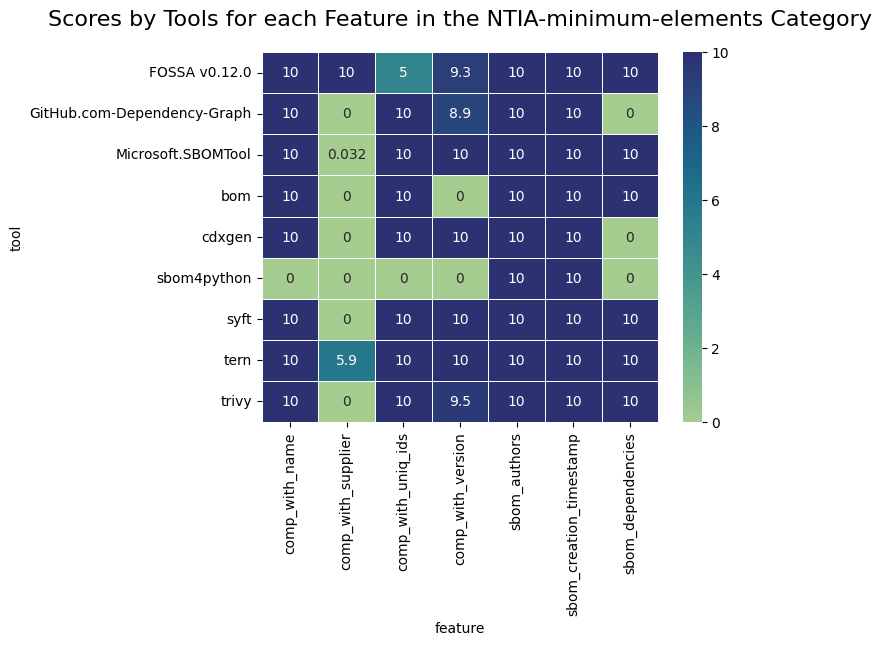

In [41]:
#| hide
display_category_qscores_heatmap(feature_qscores, ['NTIA-minimum-elements'])

In [42]:
#| export

import matplotlib.pyplot as plt
from IPython.core.display import HTML
import seaborn as sns

def display_qscores_heatmap(
    feature_qscores,  # DataFrame with the quality scores for each feature in each category for all tools.
    ) -> None:
    """
    This function display a heatmap showing scores by tools for each SBOM quality category.    
    """
    
    chart_data = sbomqs_score_by_cat(feature_qscores).melt(id_vars=["category"])
    chart_data.columns = ['Category', 'Tool', 'Score']
    
    title = "Scores by Tools for each SBOM Quality Category"
    #display(HTML(f"<h1 style=\"background-color:powderblue;\">{title}</h1>"))
    sns.heatmap(chart_data.pivot(index="Tool", columns="Category", values="Score"), 
                linecolor='white',linewidths=0.5, annot=True, cmap="crest").set(title=title)
    plt.show()

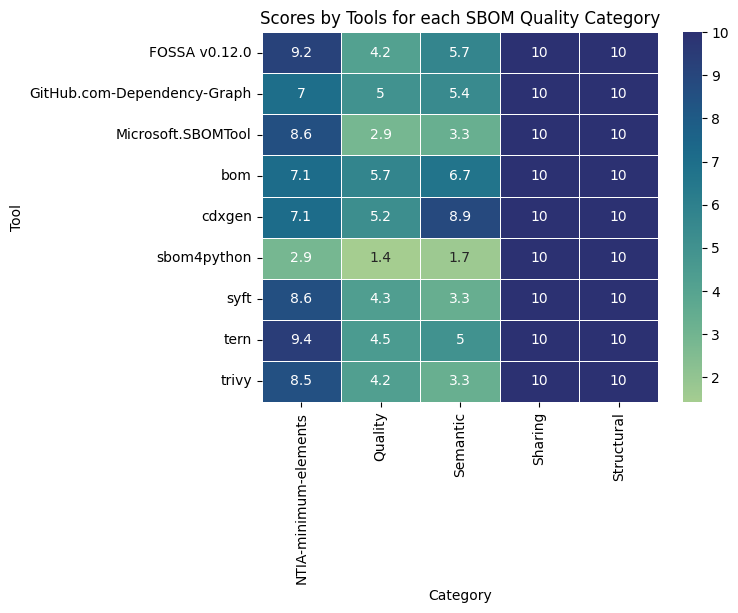

In [43]:
#| hide
display_qscores_heatmap(feature_qscores)

In [51]:
#| export

import seaborn as sns
import plotly.express as px
from plotly.graph_objects import Figure
import plotly.io as pio


def sbomqs_radar_chart(
    feature_qscores  # DataFrame with the quality scores for each feature in each category for all tools.                       
    ) -> None:
    """
    Construct a radar chart for the quality scores of the SBOMs categories for each tool.
    
    """

    pio.renderers.default = 'vscode'
    
    num_tools = feature_qscores['tool'].nunique()
    color_discrete_sequence = sns.color_palette("hls", num_tools)

    chart_data = sbomqs_score_by_cat(feature_qscores).melt(id_vars=["category"])
    chart_data.columns = ['Category', 'Tool', 'Score']

    fig = px.line_polar(chart_data, r="Score",
                        theta="Category",
                        color="Tool",
                        line_close=True,
                        color_discrete_sequence=color_discrete_sequence.as_hex(),
                        template="plotly_dark")

    fig.update_polars(angularaxis_showgrid=True,
                    radialaxis_gridwidth=1,
                    gridshape='linear',
                    bgcolor="#494b5a",
                    radialaxis_showticklabels=False,               
                    )

    fig.update_layout(paper_bgcolor="#2c2f36",
                    autosize=False,
                    width=1000,
                    height=700,)

    fig.show()
    #fig.write_image('../figs/sbomqs_radar_chart.png')



In [52]:
sbomqs_radar_chart(feature_qscores) 


In [46]:
#| default_exp core